In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


import methods.xflib as xflib

from methods.index_helpers import load_TS_params
from methods.index_helpers import load_Dst
from methods.index_helpers import load_Kp
from methods.index_helpers import load_ae
from methods.index_helpers import Kp_at
from methods.index_helpers import Ae_at

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/Thesis figures/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [2]:

# 2d plot, longitude vs L-shell:
def plot_lon(data, lonlims=None, Llims=None, clims=None):
    # --------------- Latex Plot Beautification --------------------------
    fig_width = 8 
    fig_height = 6
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    
    data_total = data['data']
    flash_lons = data['lons']
    Lshells    = data['Lshells']
    flash_lon  = flash_lons[0]
    time = data['time']
    dt = time[1]-time[0]
    tmax= time[-1] + dt
    d_lon = flash_lons[1] - flash_lons[0]
    num_lons = len(flash_lons)

    lon_max = flash_lons[-1] - flash_lons[0]
        
    logdata = np.log10(np.sum(data_total, axis=-1)*dt/tmax)
    logdata[np.isinf(logdata)] = -1000
    logdata = np.vstack([np.flipud(logdata[:,1:].T), logdata.T]).T

    maxval = np.ceil(np.max(logdata))
    clims = [maxval - 3, maxval]

    fig, ax = plt.subplots(1,1)
    xaxis = np.arange(-lon_max, lon_max + d_lon, d_lon)
    p0 = ax.pcolorfast(xaxis, Lshells, logdata, vmin=clims[0], vmax=clims[1], cmap=plt.get_cmap('jet'))

    fig.subplots_adjust(right=0.82)
    cax = fig.add_axes([0.84,0.12, 0.02, 0.75])

    cb = plt.colorbar(p0, cax=cax)
    cb.set_label('avg wave power density (J/sec/m$^3$)')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)

    ax.set_xlabel('Longitude (deg)')
    ax.set_ylabel('L shell')

    return fig, ax


(4, 4)
15
0 0
30
0 1
45
0 2
54
0 3
15
1 0
30
1 1
45
1 2
54
1 3
15
2 0
30
2 1
45
2 2
54
2 3
15
3 0
30
3 1
45
3 2
54
3 3


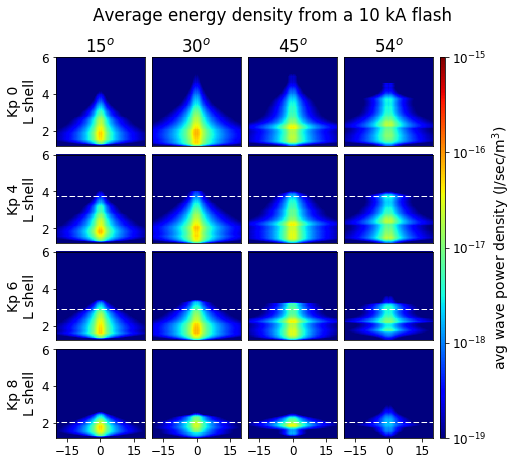

In [65]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 7
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


in_dir = '/shared/users/asousa/WIPP/lightning_power_study/outputs/nightside/mode6_v2/'

# lats = [15, 20, 25, 30, 35, 40, 45, 50]
lats = [15, 30, 45, 54]
kps = [0,4,6,8]
fig = plt.figure()

widths = [1 for x in lats]
widths.append(0.05)
gs = gridspec.GridSpec(len(kps),len(lats) + 1, width_ratios=widths)
gs.update(wspace=0.1, hspace=0.1) # set the spacing between axes.
ax = []
for k in range(len(kps)):
    for x in range(len(lats)):
        ax.append(plt.subplot(gs[k,x]))
cax = plt.subplot(gs[:,-1])
ax = np.array(ax).reshape(len(kps), len(lats))
print np.shape(ax)
clims = [-19, -15]
p = []

# Kp =  0 7.98150681167 6.10722722785
# Kp =  2 4.80296193404 5.11893314084
# Kp =  4 3.74145363494 4.25148331682
# Kp =  6 2.89254388851 3.43809307201
# Kp =  8 2.05866805608 2.49777808469
# Lpp = [7.98, 4.80, 3.74, 2.89, 2.05]
Lpp = [7.98, 3.74, 2.89, 2.05]
for k, kp in enumerate(kps):
    for x, lat in enumerate(lats):
        print lat
        print k, x
        with gzip.open(os.path.join(in_dir, 'kp%d/data/data_%g.pklz'%(kp,lat)),'rb') as file:
            data = pickle.load(file)


        data_total = data['data']
        flash_lons = data['lons']
        Lshells    = data['Lshells']
        flash_lon  = flash_lons[0]
        time = data['time']
        dt = time[1]-time[0]
        tmax= time[-1] + dt
        d_lon = flash_lons[1] - flash_lons[0]
        num_lons = len(flash_lons)

        lon_max = flash_lons[-1] - flash_lons[0]

        logdata = np.log10(np.sum(data_total, axis=-1)*dt/tmax)
        logdata[np.isinf(logdata)] = -1000
        logdata = np.vstack([np.flipud(logdata[:,1:].T), logdata.T]).T


        
        xaxis = np.arange(-lon_max, lon_max + d_lon, d_lon)
        p.append(ax[k,x].pcolorfast(xaxis, Lshells, logdata, vmin=clims[0], vmax=clims[1], cmap=plt.get_cmap('jet')))

        ax[k,x].set_ylim([1.2, 6])

        # plasmapause location:
        
        ax[k,x].plot([-25, 25],[Lpp[k],Lpp[k]],linestyle='dashed',linewidth=1, color='w')

#         if x > 0:
#             ax[k,x].set_yticks([])
#         if k < len(kps):
#             ax[k,x].set_xticks([])
        ax[k,x].set_xlim([-20,20])
cb = plt.colorbar(p[-1], cax=cax)
cb.set_label('avg wave power density (J/sec/m$^3$)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
    
for l, lat in enumerate(lats):
    ax[0,l].set_title('%d$^o$'%lat)
for k, kp in enumerate(kps):
    ax[k,0].set_ylabel('Kp %d\nL shell'%kp)
    
for l in range(len(lats)):
    for k in range(len(kps)-1):
        ax[k,l].set_xticks([])
    
for l in range(len(lats)):
    ax[-1,l].set_xticks([-15, 0, 15])
for l in range(len(lats)-1):
    for k in range(len(kps)):
        ax[k,l+1].set_yticks([])
#     ax[0].set_ylabel('L shell')

fig.suptitle('Average energy density from a %d kA flash'%(np.abs(data['I0']/1000)))
fig.subplots_adjust(right=0.8)
fig.savefig('wave_energy_vs_L.png',dpi=150)

In [52]:
print data['I0']

-10000
